In [7]:
import gym

import torch  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import time

import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "4"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [8]:
import matplotlib
import matplotlib.pyplot as plt

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

def plot_durations(y1, y2, show_result=False):
    plt.figure(1)

    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')

    plt.xlabel('Episode')
    plt.ylabel('Reward')

    plt.plot(y1, label='Reward')
    plt.plot(y2, label='ave')

    plt.legend()

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
    

# REINFORCE

In [3]:
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=LR)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = self.linear2(x)
        return F.softmax(x, dim=1)
    
    

In [4]:
EPISODE_N = 5000
MAX_STEP = 1000

LR = 1e-4
GAMMA = 0.99

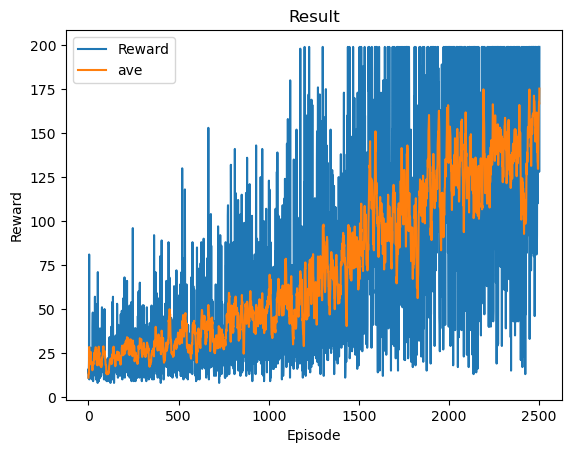

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
env = gym.make("CartPole-v0")
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128).to(device)

ep_steps_n = []
ave_ep_steps_n = []

for ep in range(EPISODE_N):
    state = env.reset()

    rewards = []
    log_probs = []

    for steps in range(MAX_STEP):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = policy_net(state)

        # choose action
        highest_prob_action = np.random.choice(env.action_space.n, p=probs.detach().cpu().numpy().squeeze(0))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action])

        # take action
        new_state, reward, done, _ = env.step(highest_prob_action)

        rewards.append(reward)
        log_probs.append(log_prob)

        if done:
            # update policy
            discounted_rewards = []
            for t in range(len(rewards)):
                Gt = 0
                for i, reward in enumerate(rewards[t:]):
                    Gt = Gt + reward * GAMMA**i

                discounted_rewards.append(Gt)

            discounted_rewards = torch.tensor(discounted_rewards)

            # normalize
            discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)

            gradient = []
            for log_prob, disc_r in zip(log_probs, discounted_rewards):
                gradient.append(-log_prob * disc_r)

            gradient = torch.stack(gradient).sum()

            policy_net.optimizer.zero_grad()
            gradient.backward()
            policy_net.optimizer.step()
            
            ep_steps_n.append(steps)
            ave_ep_steps_n.append(np.mean(ep_steps_n[-10:]))

            break

        state = new_state

    if ave_ep_steps_n[-1] > 175:
        break

    plot_durations(ep_steps_n, ave_ep_steps_n)
        
env.close()
plot_durations(ep_steps_n, ave_ep_steps_n, show_result=True)

torch.save(policy_net.state_dict(), 'CartPole-v0_REINFORCE')

In [10]:
env = gym.make("CartPole-v0")
policy_net_test = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128).to(device)

policy_net_test.load_state_dict(torch.load("CartPole-v0_REINFORCE"))
policy_net_test.eval()

for ep in range(5):
    state = env.reset()

    for steps in range(MAX_STEP):
        env.render()

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = policy_net_test(state)

        # choose action
        highest_prob_action = np.random.choice(env.action_space.n, p=probs.detach().cpu().numpy().squeeze(0))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action])

        # take action
        new_state, reward, done, _ = env.step(highest_prob_action)

        if done:
            break

        state = new_state

        time.sleep(0.01)

env.close()
